In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch


Python implementation: CPython
Python version       : 3.11.6
IPython version      : 9.4.0

numpy     : 1.26.0
pandas    : 2.3.0
matplotlib: 3.10.3
torch     : 2.2.2



In [2]:
# Loading the dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./assets/mnist",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./assets/mnist",
    train=False,
    transform=transforms.ToTensor(),
)

In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [4]:
# split train test
import torch
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

In [5]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [7]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.numpy())

print("\n Training label distribution: \n", sorted(train_counter.items()))

val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.numpy())

print("\n Validation label distribution: \n", sorted(val_counter.items()))

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.numpy())

print("\n Test label distribution: \n", sorted(test_counter.items()))


 Training label distribution: 
 [(0, 5464), (1, 6156), (2, 5474), (3, 5673), (4, 5331), (5, 4984), (6, 5431), (7, 5703), (8, 5338), (9, 5446)]

 Validation label distribution: 
 [(0, 459), (1, 586), (2, 484), (3, 458), (4, 511), (5, 437), (6, 487), (7, 562), (8, 513), (9, 503)]

 Test label distribution: 
 [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


# Zero-rule classifier / Majority class classifier


In [18]:
# what is the baseline accuracy, when we predict all records to majority class?  This is our competing score

majority_class = test_counter.most_common(1)[0]
print(f"Majority class: {majority_class}")

baseline_accuracy = majority_class[1] / sum(test_counter.values())
print("Accuracy when predicting majority class:")
print(f"Baseline accuracy:{baseline_accuracy} ({baseline_accuracy * 100:.2f}%)")

Majority class: (1, 1135)
Accuracy when predicting majority class:
Baseline accuracy:0.1135 (11.35%)


# Visual Check

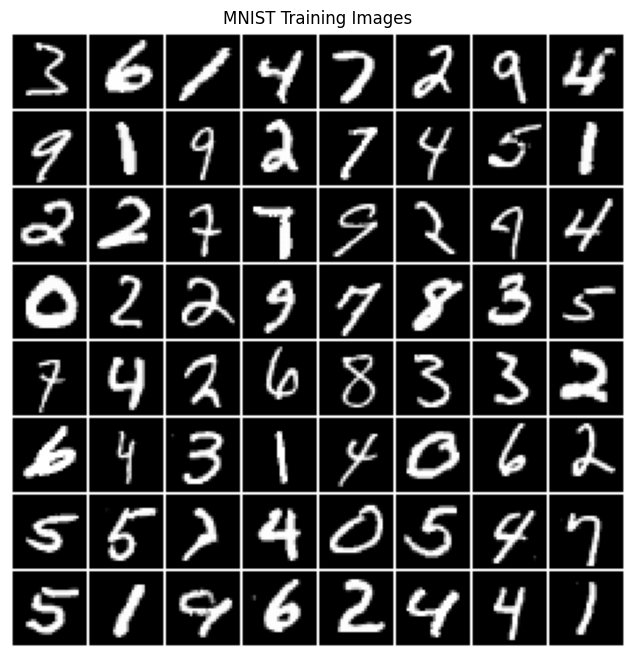

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("MNIST Training Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            images[:8*8],
            padding=1,
            pad_value=1.0,
            normalize=True,
        ),
        (1, 2, 0),
    )
)
plt.show()

# 5) implementing the model


In [33]:
images.shape #batch_size , channel, height, width

torch.Size([64, 1, 28, 28])

![MNIST Training Images](./assets/mnist/mnist-reshape.png)


In [35]:
type(images)

torch.Tensor

In [36]:
torch.flatten(images, start_dim=1).shape # batch_size, features

torch.Size([64, 784])

In [45]:
import torch


class PytorchMPL(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(

            #first hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),

            #Second hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),

            #output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits



In [46]:
# Training loop

def compute_accuracy(model, dataloader):
    correct = 0.0
    total_examples = 0.0

    for index, (features, labels) in enumerate(dataloader):
        # with torch.no_grad():
        with torch.inference_mode():  #same as no grad
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)  # because it one hot encodes y get its index for class label
        compare = predictions == labels
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [47]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PytorchMPL(num_features=784, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

n_epochs = 10

loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = model(features)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        if not batch_idx % 250:
            print(
                f"Epoch {epoch + 1:03d} / {n_epochs:03d} - "
                f"Batch {batch_idx:03d} / {len(train_loader):03d} -"
                f"Loss: {loss.item():.4f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train accuracy: {train_acc:.4f} - Val accuracy: {val_acc:.4f}")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)





Epoch 001 / 010 - Batch 000 / 860 -Loss: 2.3102
Epoch 001 / 010 - Batch 250 / 860 -Loss: 0.7155
Epoch 001 / 010 - Batch 500 / 860 -Loss: 0.8198
Epoch 001 / 010 - Batch 750 / 860 -Loss: 0.4428
Train accuracy: 0.8987 - Val accuracy: 0.9004
Epoch 002 / 010 - Batch 000 / 860 -Loss: 0.5783
Epoch 002 / 010 - Batch 250 / 860 -Loss: 0.3688
Epoch 002 / 010 - Batch 500 / 860 -Loss: 0.5375
Epoch 002 / 010 - Batch 750 / 860 -Loss: 0.3454
Train accuracy: 0.9200 - Val accuracy: 0.9238
Epoch 003 / 010 - Batch 000 / 860 -Loss: 0.1833
Epoch 003 / 010 - Batch 250 / 860 -Loss: 0.2478
Epoch 003 / 010 - Batch 500 / 860 -Loss: 0.3249
Epoch 003 / 010 - Batch 750 / 860 -Loss: 0.1961
Train accuracy: 0.9367 - Val accuracy: 0.9378
Epoch 004 / 010 - Batch 000 / 860 -Loss: 0.1831
Epoch 004 / 010 - Batch 250 / 860 -Loss: 0.1933
Epoch 004 / 010 - Batch 500 / 860 -Loss: 0.1483
Epoch 004 / 010 - Batch 750 / 860 -Loss: 0.1525
Train accuracy: 0.9464 - Val accuracy: 0.9450
Epoch 005 / 010 - Batch 000 / 860 -Loss: 0.1090


# Evaluate our model

In [51]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train accuracy: {train_acc:.4f} - Val accuracy: {val_acc:.4f} - Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9700 - Val accuracy: 0.9616 - Test accuracy: 0.9611


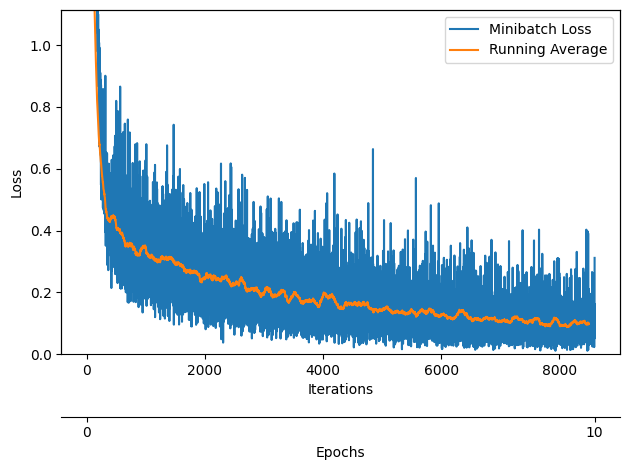

In [50]:
from helper_plotting import plot_training_loss

plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=n_epochs,
                   iter_per_epoch=len(loss_list)//n_epochs)

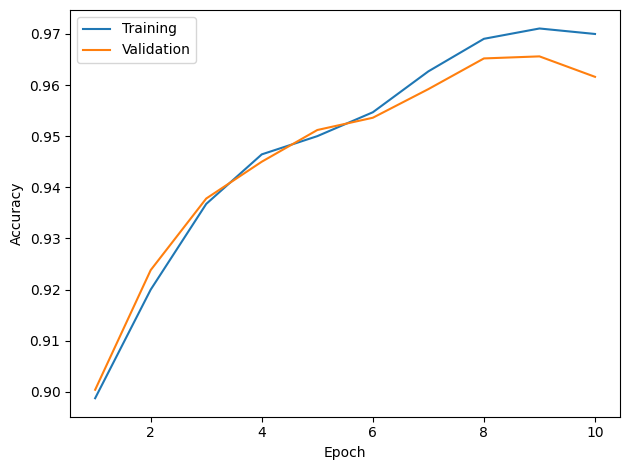

In [52]:
from helper_plotting import plot_accuracy

plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)

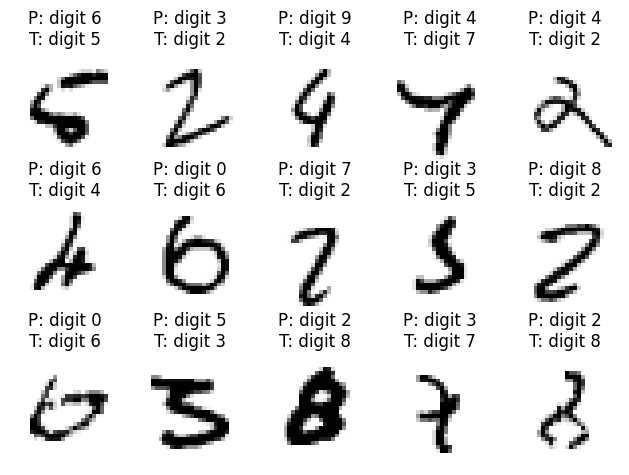

In [54]:
#8) Inspecting failure cases
from helper_plotting import show_examples


class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

show_examples(
    model=model, data_loader=test_loader, class_dict=class_dict
)